# Overview

This notebook contains all code and discussions for the __expert iteration__ of the research question involving __lesion coloration (or appearance) and malignancy__. The specific research objective is to make a predictive model that can accurately classify new samples as benign/malignant lesions, based on the image. This is an advanced version of [this intermediate module](../intermediate/Q1.ipynb) revolving around the same features.

# Table of Contents

I. [Setup](#setup)

II. [Data Retrieval](#dr)

1. [File Access](#fa)
2. [Loading & Processing](#lp)

III. [Analysis](#anl)

1. [Experimental Design](#ed)
2. [](#)

IV. [Discussion](#d)

# Setup

Refer to [this module](../novice/Data_Download.ipynb) for replicating the data-download process using the ISIC Python tool. The command is repeated below, although file/directory locations may need adjustment. 

`
python download_archive.py \
--num-images=50 \ 
--images-dir ../../sample_imgs \ 
--descs-dir ../../sample_dscs -s \ 
--seg-dir ../../sample_segs --seg-skill expert
`

The following are necessary imports for this module.

In [23]:
# data retrieval
import glob
import json
from PIL import Image

# data manipulation, analysis, and visualization
import numpy as np
import matplotlib.pyplot as plt

# Data Retrieval

# File Access

As in other modules, access the "targets" or response variables (benign/malignancy flags).

In [3]:
# getting file locations
dsc_filepaths = glob.glob('../../sample_dscs/*')
print('Descriptions: ', len(dsc_filepaths))

# extracting from json
dscs = [json.load(open(x, 'r'))['meta']['clinical'] for x in dsc_filepaths]
targets = [x['benign_malignant'] for x in dscs]

# sample output
for i in range(3):
    print('Data point #%d: %s' % (i, targets[i]))

Descriptions:  50
Data point #0: benign
Data point #1: benign
Data point #2: malignant


Initial access of the image files is similar.

In [4]:
# check that file names match with description files
img_filepaths = glob.glob('../../sample_imgs/*')

for i in range(3):
    print('Data point #%d, %s %s' % (i, dsc_filepaths[i], img_filepaths[i]))

Data point #0, ../../sample_dscs/ISIC_0000000 ../../sample_imgs/ISIC_0000000.jpeg
Data point #1, ../../sample_dscs/ISIC_0000001 ../../sample_imgs/ISIC_0000001.jpeg
Data point #2, ../../sample_dscs/ISIC_0000002 ../../sample_imgs/ISIC_0000002.jpeg


## Loading & Processing

Both segmentation approaches can be tried (refer to the earlier modules if needed):
- no segmentation (use entire original image)
- combination approach (overlay relevant segmented part of image onto black background)

Also, both color-scale approaches can be tried (refer to the earlier modules if needed):
- greyscale versions of images
- unaltered images

This makes for 4 permutations of models. Ready the color and grey images for this series as follows:

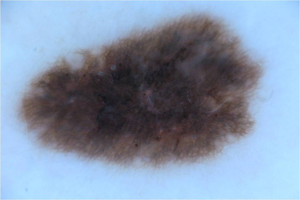

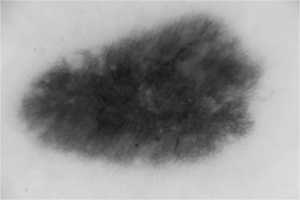

In [20]:
color_images = [Image.open(x).convert('RGB') for x in img_filepaths]
grey_images = [Image.open(x).convert('L') for x in img_filepaths]
display(color_images[0].resize((300,200)), grey_images[0].resize((300,200)))

For the non-segmented data arrays, convert to `numpy` format. Notice that the grey-scale images naturally only have 1 pixel value in each location of an image, so are of a different shape.

In [24]:
X_full_color = [np.array(x) for x in color_images]
X_full_grey = [np.array(x) for x in grey_images]
print('Example shape for non-segmented, color image', X_full_color[0].shape)
print('Example shape for non-segmented, black-and-white image', X_full_grey[0].shape)

Example shape for non-segmented, color image (767, 1022, 3)
Example shape for non-segmented, black-and-white image (767, 1022)


The segmented approach is a little different, and requires a previously-seen process for cutting the segmented lesion part from each image, and turning the rest of the frame black (i.e., 0-valued).

In [25]:



# matt segmentation approach
# np

# Analysis

## Experimental Design

For the integrity of later tests, it is necessary to recognize the shape of the data. The split between benign/malignant labels in the table is manageable. TBD WITH FULL DATA: "with a sizable sample of *n*, there are more *x* but not by enough of a percentage (or some similar comment) to make a difference.

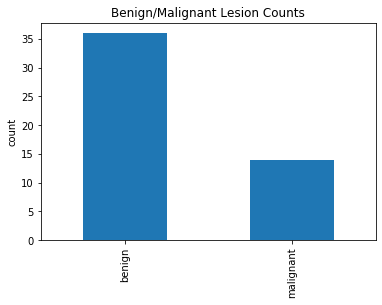

In [14]:
df.malignancy.value_counts().plot(kind='bar', title='Benign/Malignant Lesion Counts')
plt.ylabel('count')
plt.show()

Even more important is the split between the different lesion diagnoses in the table, since too much of a skew may cause issues with statistical assumptions.

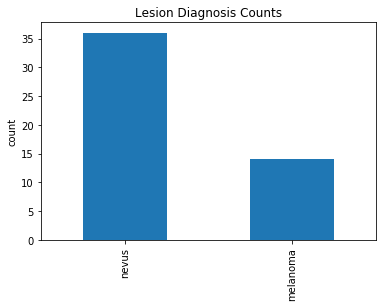

In [15]:
df.diagnosis.value_counts().plot(kind='bar', title='Lesion Diagnosis Counts')
plt.ylabel('count')
plt.show()

The following issues emerge:

1. There is an 'unknown' category whose size eclipses most other diagnoses, but without any additional clinical/background information. 
2. Given the categorical variables, it cannot be determined that the data approximates a Gaussian distribution. There are many categories, and a statistical test is needed to compare all of them to determine any significant differences in maligant lesion occurrence. 
3. Some categories are sparsely populated (with only tens or single-digit amounts of samples, compared to the hundreds/thousands of others).

To which the following reasoning can be applied:

1. 'Unknown' could be referring to a diagnosis that is not yet known, or a diagnosis that is known but could not be accurately identified by the personnel or equipment available. So, it is better to exclude it, rather than compare it with other groups without any clarification as to its nature.

In [27]:
# standardize all string values
df.malignancy = df.malignancy.apply(lambda x: x.lower())
df.diagnosis = df.diagnosis.apply(lambda x: x.lower())
print('N:', len(df))

# drop unknown diagnoses
df = df[df.diagnosis != 'unknown']
print('N (after dropping):', len(df))

N: 50
N (after dropping): 50


2. The members of each group are independent, so no paired test is appropriate. There is 1 independent variable (diagnosis) with more than 2 groups, and a non-ranked outcome. Given the absent normality assumption, the Chi-Square Test of Independence is most appropriate. 
3. Chi-Square tests demand minimum expected counts for each group: no group can have expected value < 0, and at most 20% of groups can have expected value < 5. To calculate expected values, first construct a contingency table.

In [38]:
df_crosstab = pd.crosstab(df.diagnosis, df.malignancy)
df_crosstab

malignancy,benign,malignant
diagnosis,,
melanoma,0,14
nevus,36,0


The expected value for each cell is `row_total * column_total / grand_total`. These can be determined for each diagnosis. First restructure the contingency table.

In [84]:
# flatten contingency table so each diagnosis 'row' has benign/malignant counts
df_contingency = df_crosstab.rename_axis(None, axis=1).reset_index()
df_contingency.head()

,diagnosis,benign,malignant
0,melanoma,0,14
1,nevus,36,0


Store grand and column totals and assert they line up with initial data.

In [89]:
grand_total = len(df)
total_b = df_contingency.benign.sum()
total_m = df_contingency.malignant.sum()

print('Benign: %d, Malignant: %d' % (total_b, total_m))
df.malignancy.value_counts()

Benign: 36, Malignant: 14


benign       36
malignant    14
Name: malignancy, dtype: int64

Create row totals for ease.

In [85]:
df_contingency['row_total'] = df_contingency.benign + df_contingency.malignant
df_contingency.head()

,diagnosis,benign,malignant,row_total
0,melanoma,0,14,14
1,nevus,36,0,36


Compute expected values for the entire benign and malignant columns at once, per given formula.

In [94]:
df_exp = df_contingency.copy()
df_exp['expected_benign'] = df_exp.row_total * total_b / grand_total
df_exp['expected_malignant'] = df_exp.row_total * total_m / grand_total
df_exp

,diagnosis,benign,malignant,row_total,expected_benign,expected_malignant
0,melanoma,0,14,14,10.08,3.92
1,nevus,36,0,36,25.92,10.08


Gather occurrences of <5 expected value in either columns. Observe the droppage that will be needed.

In [124]:
# get rows where the <5 condition is true, for both columns
occurrences_benign = df_exp[df_exp.expected_benign < 5]
occurrences_malignant = df_exp[df_exp.expected_malignant < 5]

# find needed droppage
total_occurrences = len(occurrences_benign) + len(occurrences_malignant)
limit = int(0.2 * len(df))
diff = total_occurrences - limit

# output
if diff > 0:
    print('Reduce by %d cells' % diff)

Now, sort by *(increasing expected benign count, increasing expected malignant count)* so the lowest values are visible. This reveals the candidate diagnosis types for dropping.

In [125]:
2

2

It does not make sense to drop one cell and keep its benign/malignant counterpart; the whole diagnosis will be dropped. This results in a potential "extraneous" droppage of diagnosis types, but is necessary. 

Which leaves a list of diagnosis which are to be kept, and can be used to filter the original data. Now the data is ready for analysis.

## Testing

Stuff.

In [ ]:
scipy stats chi2 contingency?